In [1]:
import lasio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import glob
import os

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

# model = pickle.load(open("src/model/mlp_pwr_best_model.sav", 'rb'))
scaler = pickle.load(open('/home/se760/Training/volve-machine-learning/model/scaler.sav', 'rb'))

features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target = 'DT'

In [2]:
import glob
import os

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join("/home/se760/Training/volve-machine-learning/well_logs", "*.LAS")))

well_df = [0] * 5

for i in range(len(paths)):
  # read with lasio
  well = lasio.read(paths[i])

  # convert to dataframe
  df = well.df()

  # in this dataframe, depth is positioned as index, not as column
  # so better to change depth index to column
  well_df[i] = df.reset_index()

well1, well2, well3, well4, well5 = well_df

In [3]:
# lower limit
low = [2600, 3200, 2620, 3100, 3100]

# upper limit
up = [3720, 4740, 3640, 3400, 4050]

# train columns to use
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

# test columns to use
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

well_df_restrict = [0] * 5

for i in range(len(well_df)):
  # restrict depth within the given lower and upper limit
  df = well_df[i].loc[(well_df[i]['DEPTH'] >= low[i]) & (well_df[i]['DEPTH'] <= up[i])]

  if i == 0 or i == 2 or i == 3:
    # the train data, drop unwanted columns
    well_df_restrict[i] = df[train_cols]
  
  else:
    # the test data, drop unwanted columns
    well_df_restrict[i] = df[test_cols]

well1, well2, well3, well4, well5 = well_df_restrict

In [4]:
# merge dataframes
well_train = pd.concat([well1, well3, well4])
well_pred = pd.concat([well2, well5])

# assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []
for i in range(len(well_df_restrict)):
  if i == 0 or i == 2 or i == 3:
    # train data, assign names 
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_train.append(_)
  else:
    # test data, assign names
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_pred.append(_)

# concatenate inside list
import itertools

names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# include well names to the train and pred dataframe
well_train['WELL'] = names_train
well_pred['WELL'] = names_pred

# move the depth column to the right
depth_train, depth_pred = well_train.pop('DEPTH'), well_pred.pop('DEPTH')
well_train['DEPTH'], well_pred['DEPTH'] = depth_train, depth_pred

In [5]:
# Read normalized & processed data

well_train_norm_svm=pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_train_norm_svm.csv')


In [6]:
well_train_norm_svm.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.130650,-0.631876,0.031083,0.450019,1.588380,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.758080,-0.819890,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6


In [7]:
# Step 6: Preliminary Prediction 

# Define the train data
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
only_target = 'DT'

X_train = well_train_norm_svm[only_feature].values
y_train = well_train_norm_svm[only_target].values

In [8]:
# model = MLPRegressor()
# model_param = {
#     'hidden_layer_sizes':[(518,128),(64,32),(32,16),(16,8)],
#     'activation':['relu'],
#     'alpha':[(0.001),(0.01)],
#     'solver':['adam'],
#     'learning_rate':['adaptive'],
#     'learning_rate_init':[(0.01)],
#     'max_iter':[(500)],
#     'n_iter_no_change':[30],
#     'early_stopping':[True],
#     'random_state':[123],
#     'verbose':[True],
# }

# model_grid = GridSearchCV(model, model_param, cv=5, n_jobs=3, verbose=4)
# model_grid.fit(X_train, y_train)
# model_grid.score(X_train, y_train)
# print(model_grid.best_score_)
# print(model_grid.best_params_)

In [9]:
# Define the test data
well_train_norm=pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_train_norm.csv')

well_pred_1 = well_train_norm.copy()

names_train = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_test = []
y_test = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred_1.loc[well_pred_1['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  
  X_test.append(X_test_)
  y_test.append(y_test_)

# for each well 1, 3, and 4
X_test1, X_test3, X_test4 = X_test
y_test1, y_test3, y_test4 = y_test

In [10]:
from sklearn.metrics import mean_squared_error
# Create the regressor
model=MLPRegressor(
        hidden_layer_sizes=(518,128),
        alpha = 0.01,
        activation='relu',
        solver= 'adam',
        max_iter= 500,
        n_iter_no_change = 30,
        learning_rate_init = 0.01,
        verbose = True, 
        early_stopping = True)

# Fit the regressor to the training data
model.fit(X_train, y_train)

#import pickle
model = pickle.load(open('/home/se760/Training/volve-machine-learning/model/best_model.sav', 'rb'))

# Predict on well 1
y_pred1 = model.predict(X_test1)
print("R-squared of Well 1: {}".format(model.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 1: {}".format(rmse))

# Predict on well 3
y_pred3 = model.predict(X_test3)
print("R-squared of Well 3: {}".format(model.score(X_test3, y_test3)))
rmse = np.sqrt(mean_squared_error(y_test3, y_pred3))
print("RMSE of Well 3: {}".format(rmse))

# Predict on well 4
y_pred4 = model.predict(X_test4)
print("R-squared of Well 4: {}".format(model.score(X_test4, y_test4)))
rmse = np.sqrt(mean_squared_error(y_test4, y_pred4))
print("RMSE of Well 4: {}".format(rmse))

Iteration 1, loss = 0.14970972
Validation score: 0.943509
Iteration 2, loss = 0.04055806
Validation score: 0.947670
Iteration 3, loss = 0.03969989
Validation score: 0.949449
Iteration 4, loss = 0.03805973
Validation score: 0.947274
Iteration 5, loss = 0.03711177
Validation score: 0.949743
Iteration 6, loss = 0.03731640
Validation score: 0.946041
Iteration 7, loss = 0.03690216
Validation score: 0.950863
Iteration 8, loss = 0.03709076
Validation score: 0.948954
Iteration 9, loss = 0.03713969
Validation score: 0.947193
Iteration 10, loss = 0.03611549
Validation score: 0.953248
Iteration 11, loss = 0.03576360
Validation score: 0.953110
Iteration 12, loss = 0.03547065
Validation score: 0.946056
Iteration 13, loss = 0.03674081
Validation score: 0.951429
Iteration 14, loss = 0.03581959
Validation score: 0.951690
Iteration 15, loss = 0.03559378
Validation score: 0.944908
Iteration 16, loss = 0.03592027
Validation score: 0.951762
Iteration 17, loss = 0.03509908
Validation score: 0.950497
Iterat

In [11]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test1, y_pred1 = scaler.inverse_transform(y_test1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test3, y_pred3 = scaler.inverse_transform(y_test3.reshape(-1,1)), scaler.inverse_transform(y_pred3.reshape(-1,1))
y_test4, y_pred4 = scaler.inverse_transform(y_test4.reshape(-1,1)), scaler.inverse_transform(y_pred4.reshape(-1,1))

In [12]:
y_pred1

array([[102.61055709],
       [104.57862804],
       [102.96582352],
       ...,
       [ 76.84199745],
       [ 77.54274229],
       [ 79.6301979 ]])

In [13]:
# export pickle
pickle.dump(model, open('/home/se760/Training/volve-machine-learning/model/best_model.sav','wb'))



In [14]:
# Define the test data 
well_pred = pd.read_csv('/home/se760/Training/volve-machine-learning/output/well_pred.csv')

names_pred = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []
for i in range(len(names_pred)):
  # split the df with respect to its name
  test = well_pred.loc[well_pred['WELL'] == names_pred[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature)
  X_test_ = test[only_feature].values

  # define depth
  depth_ = test['DEPTH'].values
  
  X_test.append(X_test_)
  depths.append(depth_)

# for each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [15]:
print(X_test2)

[[ 0.075  2.605  9.348  8.331  7.451  8.547]
 [ 0.077  2.602  9.362  8.289  7.464  8.547]
 [ 0.078  2.599  9.545  8.247  7.405  8.547]
 ...
 [ 0.103  2.592 32.217  4.232  4.729  8.734]
 [ 0.108  2.583 29.841  4.233  4.705  8.75 ]
 [ 0.114  2.571 31.423  4.225  4.617  8.76 ]]


In [16]:
# Normalize X_test of well 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

# Predict to well 2 and 5
y_pred2 = model.predict(X_test2)
y_pred5 = model.predict(X_test5)

# Denormalize y_pred of well 2 and 5
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred5 = scaler.inverse_transform(y_pred5.reshape(-1,1))

In [17]:
print(X_test2)

[[-2.11574148e+00  1.14408482e+00 -2.04552143e+00 -1.37185878e-01
   1.35418520e+00 -6.80011603e-16]
 [-2.06903418e+00  1.13072834e+00 -2.04280884e+00 -1.40730277e-01
   1.35895282e+00 -6.80011603e-16]
 [-2.04578200e+00  1.11732870e+00 -2.00770955e+00 -1.44295717e-01
   1.33713234e+00 -6.80011603e-16]
 ...
 [-1.48570095e+00  1.08589402e+00  1.94627957e-01 -6.34555161e-01
  -5.05194640e-01  4.99600361e-16]
 [-1.37839509e+00  1.04512764e+00  5.78657098e-02 -6.34375746e-01
  -5.34605498e-01  5.82867088e-16]
 [-1.25160895e+00  9.90151513e-01  1.50129220e-01 -6.35812329e-01
  -6.45778645e-01  6.38378239e-16]]


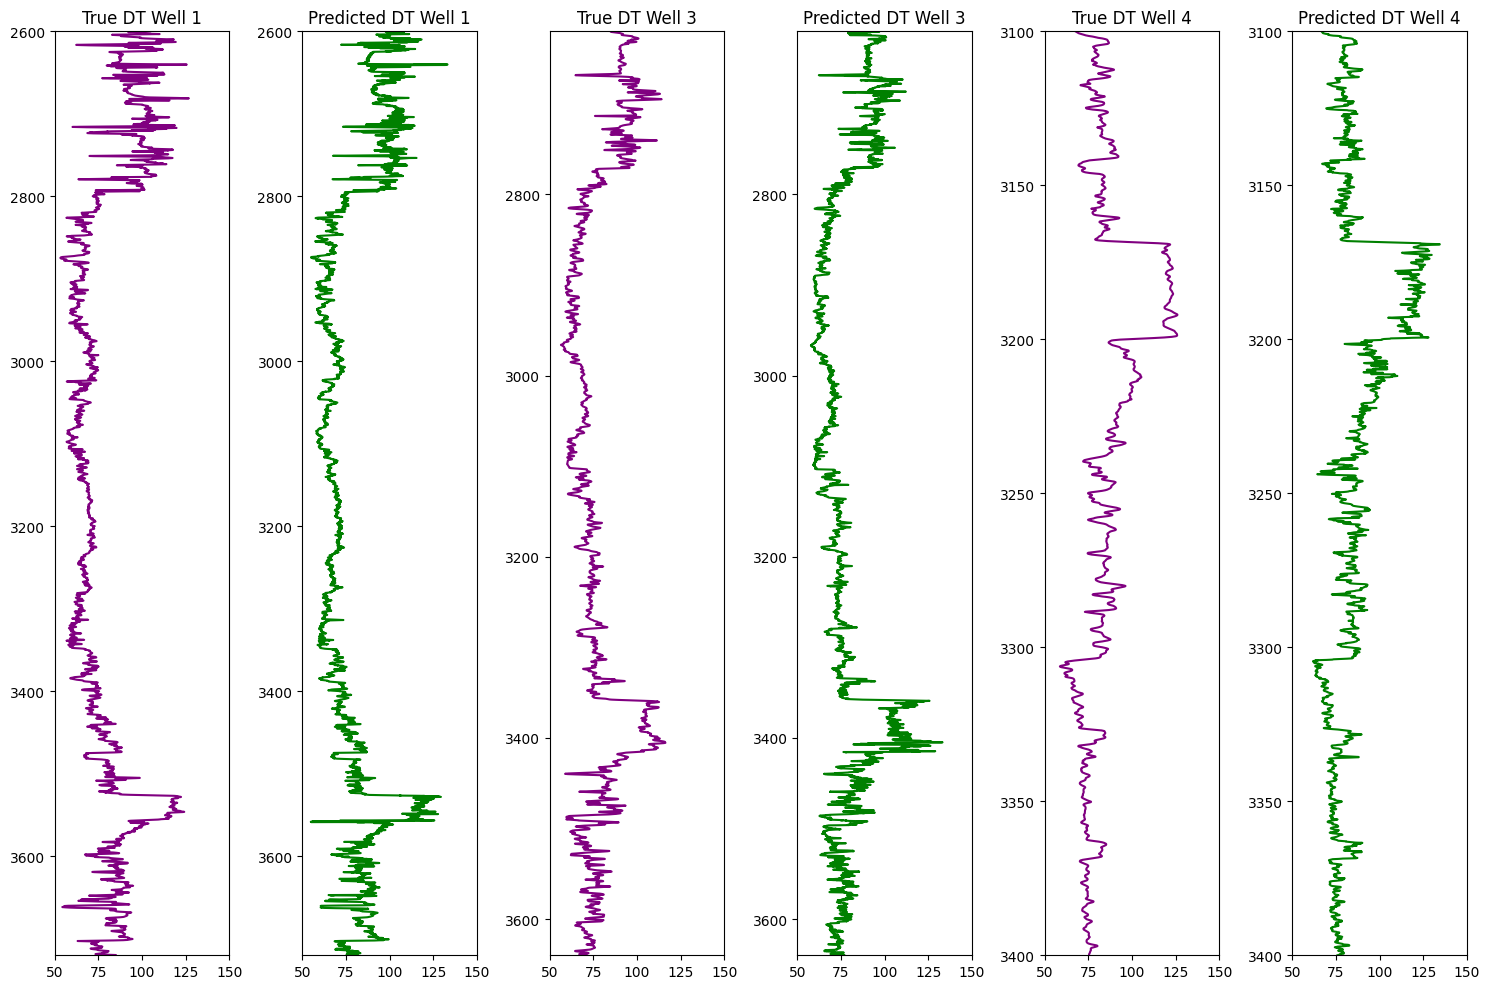

In [18]:
x = [y_test1, y_pred1, y_test3, y_pred3, y_test4, y_pred4]
y = [well1['DEPTH'], well1['DEPTH'], well3['DEPTH'], well3['DEPTH'], well4['DEPTH'], well4['DEPTH']]

color = ['purple', 'green', 'purple', 'green', 'purple', 'green']
title = ['True DT Well 1', 'Predicted DT Well 1', 'True DT Well 3', 'Predicted DT Well 3',
         'True DT Well 4', 'Predicted DT Well 4']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[i].set_xlim(50, 150)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout()

plt.show()

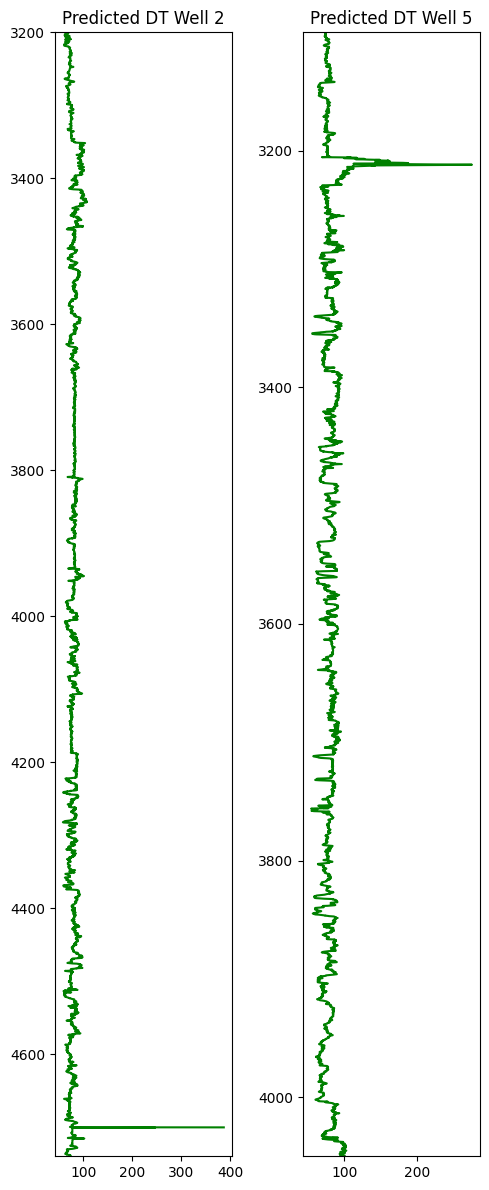

In [19]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred2, depth2, color='green')
plt.ylim(max(depth2), min(depth2))
plt.title('Predicted DT Well 2', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred5, depth5, color='green')
plt.ylim(max(depth5), min(depth5))
plt.title('Predicted DT Well 5', size=12)

plt.tight_layout()
# plt.savefig('predictwithoutlier.png')
plt.show()
